In [ ]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings 
warnings.filterwarnings('ignore')
import os

In [ ]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Done!')

In [ ]:
(market_train, news_train) = env.get_training_data()

股票数据

市场数据类型

In [ ]:
market_train.dtypes

In [ ]:
market_train.head()

每日股票数量及新闻数量比较

In [ ]:
market_train['time_d']=market_train['time'].dt.date
date_group=market_train.groupby('time_d').size()
data=[]
data.append(go.Scatter(
        x = date_group.index,
        y = date_group.values,
        name='news numbers'
    ))
layout = go.Layout(dict(
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'numbers')
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
news_train['firstCreated_date']=news_train['firstCreated'].dt.date
date_group=news_train.groupby('firstCreated_date').size()
data=[]
data.append(go.Scatter(
        x = date_group.index,
        y = date_group.values,
        name='news numbers'
    ))
layout = go.Layout(dict(title = "numbers of news",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'numbers')
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

assetCode 和 assetName的数量

In [ ]:
market_train['assetCode'].value_counts().tail(10)

In [ ]:
market_train['assetName'].value_counts().head(10)

没有assetName的assetCode数量

In [ ]:
assetNameUnknown = market_train[market_train['assetName'] == 'Unknown'].groupby('assetCode')
UnknownCodeNum = assetNameUnknown.size().reset_index('assetCode')
print("There are {} unique assets without assetName".format(UnknownCodeNum.shape[0]))

assetName is the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.

2.Volume差异

In [ ]:
market_train['volume'].describe()

In [ ]:
zeroVolume = market_train[market_train['volume'] == 0]
print("{:,} out of {:,} 'zero trading' training samples".format(len(zeroVolume[zeroVolume['universe'] == 1]), len(zeroVolume)))

苹果股票每日成交量分析

In [ ]:
mt_df = market_train[market_train['assetCode'] == 'AAPL.O']
mt_df['volume'].describe()

对应每一个assetCode，Volume更应该使用mean？相对应与市场整体volume

市场每日总体成交量

In [ ]:
volumesByTradingDay = market_train.groupby(market_train['time_d'])['volume'].sum()
trace = go.Bar(
    x = volumesByTradingDay.index,
    y = volumesByTradingDay.values
)

layout = dict(title = "Trading volumes by date",
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Volume'),
              )
data = [trace]

py.iplot(dict(data=data, layout=layout), filename='basic-line')

Volume差值大

每日开收盘价格差异

In [ ]:
def Candlestick(assetCode1,date1,date2):

    asset_df = mt_df[(mt_df['assetCode'] == assetCode1) 
                  & (mt_df['time'] > date1) 
                  & (mt_df['time'] < date2)]
    
    asset_df['high'] = asset_df['open']
    asset_df['low'] = asset_df['close']

    for ind, row in asset_df.iterrows():
        if row['close'] > row['open']:
            asset_df.loc[ind, 'high'] = row['close']
            asset_df.loc[ind, 'low'] = row['open']

    trace1 = go.Candlestick(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        open = asset_df['open'].values,
        low = asset_df['low'].values,
        high = asset_df['high'].values,
        close = asset_df['close'].values
    )

    layout = dict(title = "Candlestick chart for {}".format(assetCode1),
                  xaxis = dict(
                      title = 'Month',
                      rangeslider = dict(visible = False)
                  ),
                  yaxis = dict(title = 'Price (USD)'))
    
    data = [trace1]

    py.iplot(dict(data=data, layout=layout), filename='basic-line')  

In [ ]:
Candlestick('AAPL.O','2015-01-01','2017-01-01')

In [ ]:
market_train['daily_price_diff'] = market_train['close'] - market_train['open']
grouped = market_train.groupby('time').agg({'daily_price_diff': ['std', 'min']}).reset_index()
print(f"Average standard deviation of price change within a day in {grouped['daily_price_diff']['std'].mean():.4f}.")

NAN

In [ ]:
market_train.isna().sum()

unique

In [ ]:
market_train.nunique()

  **新闻数据**

数据类型

In [ ]:
news_train.dtypes

In [ ]:
news_train.head()

缺失值分析

In [ ]:
news_train.loc[news_train['headline']==''].head(5)

In [ ]:
news_train['headlineTag']=news_train['headlineTag'].map(lambda x:np.nan if x=='' else x)
news_train['headline']=news_train['headline'].map(lambda x:np.nan if x=='' else x)

In [ ]:
percent = (100 * news_train.isnull().sum() / news_train.shape[0]).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.title("Total Missing Value by news_train", fontsize = 20)

数值分布情况

In [ ]:
nunique=news_train.nunique()
pd.concat([nunique.rename('nunique')],axis=1)

fisrtMentionSentence相较于与sentenceCount比例

In [ ]:
(news_train['firstMentionSentence']/news_train['sentenceCount']).describe().apply(lambda x: format(x, '5.2f'))

time  sourceTimestamp firstCreated

In [ ]:
news_train.groupby(['firstCreated','assetName']).size().sort_values()

In [ ]:
news_train.loc[news_train['firstCreated']=='2016-11-29 15:16:25+00:00'].loc[news_train['assetName']=='Vale SA']

In [ ]:
print(news_train.loc[news_train['firstCreated']=='2016-11-29 15:16:25+00:00'].loc[news_train['assetName']=='Vale SA']['headline'].value_counts())

In [ ]:
(news_train['time']-news_train['firstCreated']).describe()

In [ ]:
(news_train['sourceTimestamp']-news_train['firstCreated']).describe()

In [ ]:
(news_train['time']-news_train['sourceTimestamp']).describe()

bodySize(int32) - the size of the current version of the story body in characters

wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item

In [ ]:
news_train.loc[news_train['bodySize']<news_train['wordCount']].head(5)

In [ ]:
print(news_train['wordCount'].head(5))
print(news_train['wordCount'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.wordCount)

In [ ]:
print(news_train['bodySize'].head(5))
print(news_train['bodySize'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.bodySize)


sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.

In [ ]:
print(news_train['sentimentClass'].unique())
print(news_train['sentimentClass'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.sentimentClass)

sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset

sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset

sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset

In [ ]:
print(news_train['sentimentNegative'].unique())
print(news_train['sentimentNegative'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.sentimentNegative)

In [ ]:
print(news_train['sentimentNeutral'].unique())
print(news_train['sentimentNeutral'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.sentimentNeutral)

In [ ]:
print(news_train['sentimentPositive'].unique())
print(news_train['sentimentPositive'].describe().apply(lambda x: format(x, '5.2f')))
sns.distplot(news_train.sentimentPositive)

takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have separate sequences.

In [ ]:
print(news_train['takeSequence'].describe())
sns.distplot(news_train['takeSequence'])

relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.

In [ ]:
news_train['relevance'].describe()

provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for Business Wire)

In [ ]:
news_train['provider'].value_counts().plot.bar()

urgency(int8) - differentiates story types (1: alert, 3: article)

In [ ]:
news_train['urgency'].value_counts()

In [ ]:
news_train['urgency'].value_counts().plot.bar()

companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field

In [ ]:
news_train['companyCount'].value_counts().sort_index().plot()

noveltyCount与volumeCounts相关系数
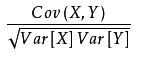

In [ ]:
print("12H %f"%news_train.noveltyCount12H.corr(news_train.volumeCounts12H))
print("24H %f"%news_train.noveltyCount24H.corr(news_train.volumeCounts24H))
print("3D %f"%news_train.noveltyCount3D.corr(news_train.volumeCounts3D))
print("5D %f"%news_train.noveltyCount5D.corr(news_train.volumeCounts5D))
print("7D %f"%news_train.noveltyCount7D.corr(news_train.volumeCounts7D))
print("24H-12H %f"%(news_train.noveltyCount24H-news_train.noveltyCount12H).corr(news_train.volumeCounts24H-news_train.volumeCounts12H))
print("3D-24H %f"%(news_train.noveltyCount3D-news_train.noveltyCount24H).corr(news_train.volumeCounts3D-news_train.volumeCounts24H))
print("5D-3D %f"%(news_train.noveltyCount5D-news_train.noveltyCount3D).corr(news_train.volumeCounts5D-news_train.volumeCounts3D))
print("7D-5H %f"%(news_train.noveltyCount7D-news_train.noveltyCount5D).corr(news_train.volumeCounts7D-news_train.volumeCounts5D))

**noveltyCount**
The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.

In [ ]:
print("24H-12H")
print((news_train['noveltyCount24H']-news_train['noveltyCount12H']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['noveltyCount24H']-news_train['noveltyCount12H']).value_counts().head(20))
(news_train['noveltyCount24H']-news_train['noveltyCount12H']).value_counts().rename('count').plot()

In [ ]:
print("3D-24H")
print((news_train['noveltyCount3D']-news_train['noveltyCount24H']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['noveltyCount3D']-news_train['noveltyCount24H']).value_counts().head(20))

In [ ]:
print("5D-3D")
print((news_train['noveltyCount5D']-news_train['noveltyCount3D']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['noveltyCount5D']-news_train['noveltyCount3D']).value_counts().head(20))

In [ ]:
print("7D-5D")
print((news_train['noveltyCount7D']-news_train['noveltyCount5D']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['noveltyCount7D']-news_train['noveltyCount5D']).value_counts().head(20))

**volumeCounts**
the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.

In [ ]:
print("24H-12H")
print((news_train['volumeCounts24H']-news_train['volumeCounts12H']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['volumeCounts24H']-news_train['volumeCounts12H']).value_counts().head(20))

In [ ]:
print("3D-24H")
print((news_train['volumeCounts3D']-news_train['volumeCounts24H']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['volumeCounts3D']-news_train['volumeCounts24H']).value_counts().head(20))

In [ ]:
print("5D-3D")
print((news_train['volumeCounts5D']-news_train['volumeCounts3D']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['volumeCounts5D']-news_train['volumeCounts3D']).value_counts().head(20))

In [ ]:
print("7D-5D")
print((news_train['volumeCounts7D']-news_train['volumeCounts5D']).describe(percentiles=[0.1,0.3,0.5,0.75,0.9,0.95,0.98,0.99,1]))
print((news_train['volumeCounts7D']-news_train['volumeCounts5D']).value_counts().head(20))

sourceId数量情况

sourceId(object) - an Id for each news item

In [ ]:
news_train['sourceId'].value_counts()

相同sourceId的情况，一个新闻与多个企业有关，因为每个企业的relevance，sentimentClass不相同，所以分开

In [ ]:
news_train.loc[news_train['sourceId']=='d7ad319ee02edea0']

In [ ]:
text = ' '.join(news_train['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

headlineTag的出现频率统计

headlineTag(object) - the Thomson Reuters headline tag for the news item

In [ ]:
news_train.loc[news_train['headlineTag']!='']['headlineTag'].str.split(' ',expand=True).stack().reset_index(level=1, drop=True).value_counts().head(20)

In [ ]:
news_train.loc[news_train['headlineTag']!='']['headlineTag'].value_counts().head(20)

audiences数量的频率

audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)

In [ ]:
news_train['audiencesLen'] = news_train['audiences'].map(lambda x: len(eval(x)))

In [ ]:
news_train['audiencesLen'].describe()